<a href="https://colab.research.google.com/github/ertgrulyksk/Airline_Passenger_Number_Forecast_with_RNN_Deep_Learning/blob/main/Airline_Passenger_Number_Forecast_with_RNN_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime as dt
import numpy as np
import urllib
import pandas as pd
import seaborn as sns
import random ,os ,glob
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import itertools
from sklearn.utils import shuffle
from urllib.request import urlopen
import warnings
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense,Dropout,SpatialDropout2D,SimpleRNN

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df=pd.read_csv("passengers.csv")

In [5]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [7]:
df.columns=["Month","Passengers"]

In [8]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [9]:
df.shape

(145, 2)

In [10]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [11]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [13]:
df=df[:144]

In [14]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [16]:
df["Month"]=pd.to_datetime(df["Month"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [18]:
print(df["Month"].min())

1949-01-01 00:00:00


In [19]:
print(df["Month"].max())

1960-12-01 00:00:00


In [20]:
df.index=df["Month"]

In [21]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [22]:

df.drop("Month",axis=1, inplace=True)

In [23]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [25]:
results_df=df.copy()

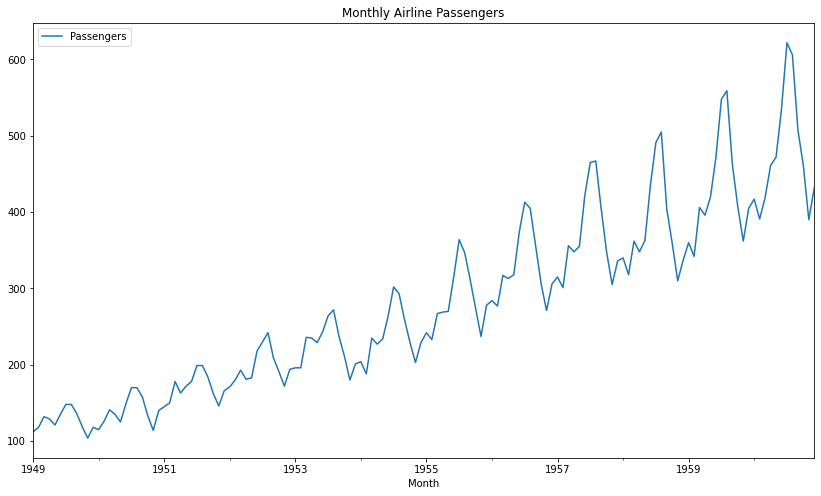

In [26]:
df.plot(figsize=(14,8),title="Monthly Airline Passengers")

In [27]:
data=df["Passengers"].values

In [28]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [29]:
type(data[0:5])

numpy.ndarray

In [30]:
type(data[0])

numpy.float64

In [31]:
data=data.astype("float32")

In [32]:
data.shape

(144,)

In [33]:
data=data.reshape(-1,1)

In [34]:
data.shape

(144, 1)

In [35]:
def split_data(dataframe,test_size):
  position=int(round(len(dataframe)*(1-test_size)))
  train=dataframe[:position]
  test=dataframe[position:]
  return train,test,position

In [36]:
train,test,position=split_data(data,0.33)

In [37]:
print(train.shape,test.shape)

(96, 1) (48, 1)


In [38]:
scaler_train=MinMaxScaler(feature_range=(0,1))

In [39]:
train=scaler_train.fit_transform(train)

In [40]:
scaler_test=MinMaxScaler(feature_range=(0,1))

In [41]:
test=scaler_test.fit_transform(test)

In [43]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [44]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [45]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [46]:
lookback=1

In [47]:
X_train,y_train=create_features(train,lookback)

In [48]:
X_test,y_test=create_features(test,lookback)

In [49]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [50]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [51]:
model = Sequential()
model.add(SimpleRNN(units=50,activation='relu', 
                    input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.20))
model.add(Dense(1))

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [54]:
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1, mode='min'),
        ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',save_best_only=True,save_weights_only=False,verbose=1)]

In [55]:
history=model.fit(x=X_train,y=y_train, epochs=50, batch_size=1,callbacks=callbacks,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/50
84/95 [=========================>....] - ETA: 0s - loss: 0.0097
Epoch 1: val_loss improved from inf to 0.03434, saving model to mymodel.h5
95/95 [==============================] - 2s 7ms/step - loss: 0.0121 - val_loss: 0.0343
Epoch 2/50
74/95 [======================>.......] - ETA: 0s - loss: 0.0164
Epoch 2: val_loss improved from 0.03434 to 0.02483, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0248
Epoch 3/50
81/95 [========================>.....] - ETA: 0s - loss: 0.0103
Epoch 3: val_loss improved from 0.02483 to 0.02215, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0221
Epoch 4/50
82/95 [========================>.....] - ETA: 0s - loss: 0.0113
Epoch 4: val_loss improved from 0.02215 to 0.02085, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0208
Epoch 5/50
92/95 [======================

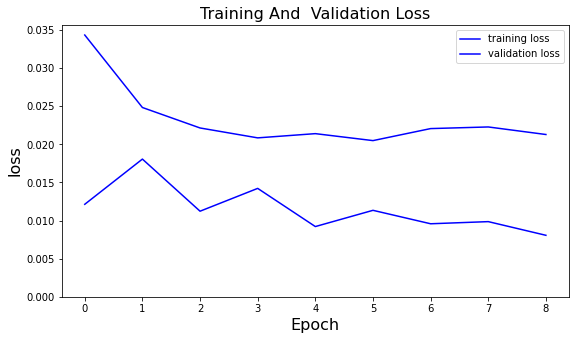

In [56]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],color="b",label="training loss")
plt.plot(history.history["val_loss"],color="b",label="validation loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training And  Validation Loss",fontsize=16)
plt.show()

In [57]:
loss=model.evaluate(X_test,y_test,batch_size=1)
print(100.0*loss)

47/47 [==============================] - 0s 3ms/step - loss: 0.0213
2.1290594711899757


In [58]:
train_predict=model.predict(X_train)

3/3 [==============================] - 1s 13ms/step


In [59]:
test_predict=model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


In [60]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [61]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [62]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))

In [63]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))

In [64]:
print(train_rmse)

23.758919


In [65]:
print(test_rmse)

46.838066


In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [67]:
train_prediction_df=results_df[lookback:position]

In [68]:
train_prediction_df["Predicted"]=train_predict

In [69]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,130.821136
1949-03-01,132.0,135.138580
1949-04-01,129.0,146.597733
1949-05-01,121.0,143.841858
1949-06-01,135.0,137.457138


In [70]:
test_prediction_df= results_df[position+lookback:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,332.927643
1957-03-01,356.0,324.653625
1957-04-01,348.0,369.055969
1957-05-01,355.0,361.707031
1957-06-01,422.0,368.137390


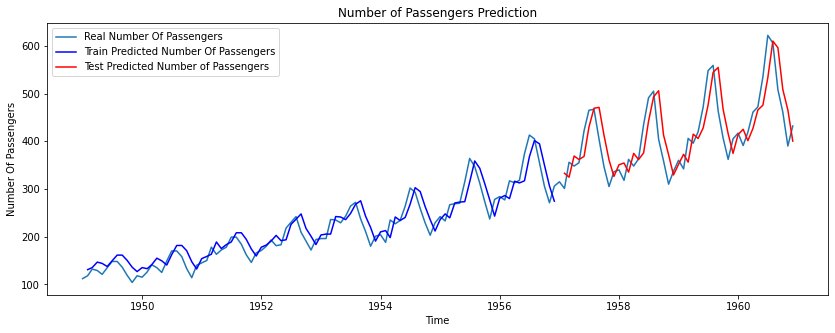

In [71]:
plt.figure(figsize=(14,5))
plt.plot(results_df,label="Real Number Of Passengers")
plt.plot(train_prediction_df["Predicted"],color="blue",label="Train Predicted Number Of Passengers")
plt.plot(test_prediction_df["Predicted"],color="red",label="Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number Of Passengers")
plt.legend()
plt.show()